In [34]:
import numpy as np
import pickle, gzip
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import time
import os
from copy import deepcopy
from scipy.special import expit # Vectorized sigmoid function
from scipy.special import softmax as softmax_

def show(image):
    plt.figure(figsize=(10,10))
    new = image.copy()
    if image.shape == 3:                    # Switch R and B channels so it shows up as correctly as R,G,B, if image is 3-channel
        new[:,:,0] = image[:,:,2]
        new[:,:,2] = image[:,:,0]
    plt.imshow(new, cmap = "gray")

### Load data

In [2]:
# Load MNIST data

with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    train_data, val_data, test_data = pickle.load(f, encoding="latin1")
    # train_data: tuple of (x_train, y_train), where x_train.shape = (50000, 784) and y_train.shape = (50000, 1)
    # val_data: tuple of (x_val, y_val), where x_val.shape = (10000, 784) and y_val.shape = (10000, 1)
    # test_data: tuple of (x_test, y_test), where x_test.shape = (10000, 784) and y_test.shape = (10000, 1)

x_train, y_train = train_data
x_val, y_val = val_data
x_test, y_test = test_data

# Combine training and validation data
x_train = np.concatenate((x_train, x_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

# Reshape x
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# One-hot encode labels
y_train = np.eye(10)[y_train].reshape((-1, 10, 1))
y_test = np.eye(10)[y_test].reshape((-1, 10, 1))

# Zip data and labels into tuples
train_data = list(zip(x_train, y_train))
test_data = list(zip(x_test, y_test))

# Shuffle training data
np.random.shuffle(train_data)

### Model constructor

In [54]:
# Constructor for neural network
# Adapted from Nielsen textbook http://neuralnetworksanddeeplearning.com/chap1.html and https://towardsdatascience.com/mnist-handwritten-digits-classification-from-scratch-using-python-numpy-b08e401c4dab and https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb

class Model(object):

    # Fully connected neural network with layer i having sizes[i] neurons
    def __init__(self, sizes, weights=None, biases=None):
        self.num_layers = len(sizes)
        self.sizes = sizes

        # Initialize weights & biases if not provided
        if weights is None:
            self.weights = [np.random.randn(y, x) for y, x in zip(sizes[1:], sizes[:-1])] # Initialize weights array of shape (num_neurons_i, num_neurons_i-1) for each layer i except the input layer
        else:
            self.weights = weights
        
        if biases is None:
            self.biases = [np.random.randn(y, 1) for y in sizes[1:]] # Initialize biases array of shape (num_neurons_i, 1) for each layer i except the input layer
        else:
            self.biases = biases

        # Store initial weights and biases
        self.initial_weights = self.weights
        self.initial_biases = self.biases
        
        # Initialize training history
        self.history = {'train': {'acc':[], 'loss':[]}, 'val': {'acc':[], 'loss':[]}, 'latent':[], 'weights':[], 'biases':[]}

        # Number of parameters
        print(f'Number of model parameters: {sum(np.prod(w.shape) for w in self.weights) + sum(np.prod(b.shape) for b in self.biases)}')

    # Activation functions
    def activation(self, x):
        # x is a matrix with nrows = num_hidden_neurons and ncols = batch_size generated by hidden layer affine transformation
        # def sigmoid(x):
        #     # Overflow-safe elementwise sigmoid function (https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/)
        #     if x > 0:
        #         return 1 / (1 + np.exp(-x))
        #     else:
        #         return np.exp(x) / (1 + np.exp(x))
        # return np.vectorize(sigmoid)(x) # Vectorize sigmoid function to apply to each element of matrix
        return np.exp(x) / (1 + np.exp(x))

    # Derivative of activation function
    def activation_der(self, x):
        return self.activation(x) * (1 - self.activation(x))

    # Softmax function
    # Overflow-safe softmax function (https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/)
    def softmax(self, x):
        # x is a matrix with nrows = num_hidden_neurons and ncols = batch_size generated by hidden layer affine transformation
        # return np.exp(x) / np.sum(np.exp(x), axis=0)
        return softmax_(x, axis = 0)
        # return np.exp(x) / (1 + np.exp(x))

    # Derivative of softmax function
    def softmax_der(self, x):
        return self.softmax(x) * (1 - self.softmax(x))        

    # Loss function
    def loss(self, y_true, y_pred):
        return np.mean(np.sum(np.nan_to_num(-y_true*np.log(y_pred)-(1-y_true)*np.log(1-y_pred)), axis = 0)) # Cross entropy loss
        # return np.mean(((y_true - y_pred)**2)) # mean squared error

    # Derivative of loss function
    def loss_der(self, y_true, y_pred):
        return y_pred - y_true # Derivative of cross entropy loss
        # return 2*(y_pred - y_true) # Derivative of mean squared error

    # Backpropagation
    # Input x,y is single training example
    # Returns (nabla_b, nabla_w), where nabla_b is list of gradients of cost with respect to biases (one for each layer) and nabla_w is list of gradients of cost with respect to weights (one for each layer)
    def backprop(self, x, y):
        # Initialize lists of gradients for each layer
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        ###### Forward pass, storing weighted inputs (z) and activations for each layer ######
        activation = x # Initialize activation with input
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the weighted input z vectors, layer by layer
        # Iterate through each layer
        for i, tup in enumerate(zip(self.biases, self.weights)):
            b, w = tup # Unpack biases and weights
            z = np.dot(w, activation) + b # Compute weighted input z
            zs.append(z) # Store weighted input z          
            if i == (self.num_layers - 2):
                # If last layer, apply softmax
                activation = self.softmax(z)
            else:
                # If not last layer, apply activation function
                activation = self.activation(z)
            activations.append(activation) # Store activation

        ###### Backward pass, computing gradients of cost with respect to biases and weights ######
        # Get gradients for output layer
        delta = self.loss_der(y, activations[-1]) * self.softmax_der(zs[-1]) # Hadamard product of loss gradient and softmax derivative for output layer
        nabla_b[-1] = delta # Store gradient of cost with respect to biases of last layer
        nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Store gradient of cost with respect to weights of last layer
        # Iterate through each layer in reverse order, starting from second to last layer
        for l in range(2, self.num_layers):
            z = zs[-l] # Retrieve weighted input z for current layer
            delta = np.dot(self.weights[-l+1].transpose(), delta) * self.activation_der(z) # Compute gradient of cost with respect to weighted input z
            nabla_b[-l] = delta # Store gradient of cost with respect to biases of current layer
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Store gradient of cost with respect to weights of current layer

        # Sum columns of nabla_b matrices to get overall bias gradients for batch
        nabla_b = [np.sum(nabla_b[i], axis=1).reshape(nabla_b[i].shape[0], 1) for i in range(len(nabla_b))]

        # Get training performance
        # print(activations[-1])
        # print(y)
        acc = np.mean(np.argmax(activations[-1], axis=0) == np.argmax(y, axis=0)) # For each column of activations[-1], get predicted label and compare to true label
        loss = self.loss(y, activations[-1]) # Compute loss
        # print(f'Training accuracy: {accuracy}')
        # print(f'Training loss: {loss}')

        return nabla_b, nabla_w, acc, loss

    # Model training using SGD
    # training_data is a list of tuples (x, y) representing the training inputs and the desired outputs
    def fit(self, training_data, epochs = 10, batch_size = 10, learning_rate = 1, decay_strength = 1, validation_size=0.3, shuffle_order=None, store_latent_vecs=False, verbose=2):
        
        # Take last portion of training data as validation data
        training_data = training_data[:-int(validation_size*len(training_data))]
        val_data = training_data[-int(validation_size*len(training_data)):]

        x_train = np.array([x for x, y in training_data])[:,:,0].T # Retrieve matrix of training examples where each column is a training example
        y_train = np.array([y for x, y in training_data])[:,:,0].T # Retrieve matrix of training labels where each column is the one-hot encoded vector

        ## Store baseline model characteristics (before training)
        # Evaluate model on training data
        train_acc, train_loss = self.evaluate(training_data)
        # Evaluate model on validation data
        val_acc, val_loss = self.evaluate(val_data)
        print(f"Baseline characteristics: Training accuracy: {train_acc:.4f}. Validation accuracy: {val_acc:.4f}. Training loss: {train_loss:.4f}. Validation loss: {val_loss:.4f}")
        # Update global history
        self.history['train']['acc'].append(train_acc)
        self.history['train']['loss'].append(train_loss)
        self.history['val']['acc'].append(val_acc)
        self.history['val']['loss'].append(val_loss)
        # Store latent vectors
        if store_latent_vecs:
            vecs = self.feedforward(x_train, layer_num = 2).T
            labs = np.argmax(y_train, axis=0)
            self.history['latent'].append(list(zip(vecs, labs))) # Store latent representation of training data before training
        # Store layer weights
        self.history['weights'].append(self.weights)
        # Store layer biases
        self.history['biases'].append(self.biases)

        # Iterate through each epoch
        print(f'Training on {len(training_data)} examples, validating on {len(val_data)} examples')
        for j in range(epochs):
            # Initialize epoch training accuracy and loss history
            train_acc = []
            train_loss = []
            # Get time
            start_time = time.time()

            # Adjust learning rate for current epoch based on decay strength
            learning_rate_adj = learning_rate/(1 + decay_strength * j)

            # Shuffle training data in preparation for SGD batching
            if shuffle_order is None:
                np.random.shuffle(training_data) # Shuffle training data randomly
            else:
                training_data = np.array(training_data, dtype=object)[shuffle_order[j]] # Shuffle training data according to order provided
            # Construct training batches for SGD
            batches = [training_data[k:k+batch_size] for k in range(0, len(training_data), batch_size)]
            # Iterate through all batches
            for batch in batches:
                x_batch = np.array([x for x, y in batch])[:,:,0].T # Retrieve matrix of training examples where each column is a training example
                y_batch = np.array([y for x, y in batch])[:,:,0].T # Retrieve matrix of training labels where each column is the one-hot encoded vector

                nabla_b_, nabla_w_, acc, loss = self.backprop(x_batch, y_batch) # Compute loss gradients for each layer for whole batch

                # Update epoch training accuracy and loss history for whole batch
                train_acc.append(acc)
                train_loss.append(loss)

                # Update weights and biases for each layer using average loss gradients
                self.weights = [w-(learning_rate_adj*nw/batch_size) for w, nw in zip(self.weights, nabla_w_)] # Need to divide by batch size to get average gradient per example
                self.biases = [b-(learning_rate_adj*nb/batch_size) for b, nb in zip(self.biases, nabla_b_)] # Need to divide by batch size to get average gradient per example
            
            # Compute epoch training accuracy and loss
            train_acc, train_loss = np.mean(train_acc), np.mean(train_loss)
            # Evaluate model on validation data
            val_acc, val_loss = self.evaluate(val_data)
            # Get time
            end_time = time.time()
            # Print epoch number (epochs start at 1)
            if verbose >= 2:
                print(f"Epoch {j+1} complete. Time taken: {end_time - start_time:.2f} seconds.")
            if verbose >= 1:
                print(f"Learning rate: {learning_rate_adj:.4f}. Training accuracy: {train_acc:.4f}. Validation accuracy: {val_acc:.4f}. Mean training loss: {train_loss:.4f}. Mean validation loss: {val_loss:.4f}. Mean weight gradients: {[np.around(np.mean(np.abs(nw)), 4) for nw in nabla_w_]}.")

            # Update global history
            self.history['train']['acc'].append(train_acc)
            self.history['train']['loss'].append(train_loss)
            self.history['val']['acc'].append(val_acc)
            self.history['val']['loss'].append(val_loss)
            # Store latent vectors
            if store_latent_vecs:
                vecs = self.feedforward(x_train, layer_num = 2).T
                labs = np.argmax(y_train, axis=0)
                self.history['latent'].append(list(zip(vecs, labs))) # Store latent representation of training data before training
            # Store layer weights
            self.history['weights'].append(self.weights)
            # Store layer biases
            self.history['biases'].append(self.biases)

        print("Training complete.")

    def evaluate(self, test_data):
        x_test = np.array([x for x, y in test_data])[:,:,0].T # Retrieve matrix of training examples where each column is a training example
        y_test = np.array([y for x, y in test_data])[:,:,0].T # Retrieve matrix of training labels where each column is the one-hot encoded vector

        acc = np.mean(np.argmax(self.feedforward(x_test), axis=0) == np.argmax(y_test, axis=0))
        loss = self.loss(y_test, self.feedforward(x_test)) 

        return acc, loss

    # Get feedforward activations for given layer (default is last layer)
    # Equivalent to Tensorflow get_layer()
    def feedforward(self, x, layer_num = None):
        # Dynamically update activations for each layer while moving forward through the network, starting with shape (input_size, 1) and ending with shape (output_size, 1)
        if layer_num is None:
            layer_num = self.num_layers - 1
        activations = x
        current_layer = 1
        while current_layer <= layer_num:
            # If current layer is last layer, return softmax activations
            if current_layer == self.num_layers - 1:
                activations = self.softmax(np.dot(self.weights[current_layer - 1], activations) + self.biases[current_layer - 1])
            else:
                activations = self.activation(np.dot(self.weights[current_layer - 1], activations) + self.biases[current_layer - 1])
            current_layer += 1
        return activations

### Set global params

In [63]:
# Model architecture
sizes = [784, 30, 2, 10]
epochs = 48
batch_size = 60
learning_rate = 5
decay_strength = 1
validation_size=0.3

# Set seed for reproducibility
np.random.seed(1)

# Initialize weights array of shape (num_neurons_i, num_neurons_i-1) for each layer i except the input layer
weights = [np.random.randn(y, x) for y, x in zip(sizes[1:], sizes[:-1])]

# Initialize biases array of shape (num_neurons_i, 1) for each layer i except the input layer
biases = [np.random.randn(y, 1) for y in sizes[1:]] 

# Initialize list of data indices for data shuffling per epoch
shuffle_order = [np.random.permutation(int(len(train_data)*(1 - validation_size))) for i in range(epochs)]

### Verify that model training is reproducible

In [64]:
# Build & train first model
model1 = Model(sizes, weights, biases)
model1.fit(train_data, epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, decay_strength = decay_strength, validation_size = validation_size, shuffle_order = shuffle_order, store_latent_vecs = False)
test_acc, test_loss = model1.evaluate(test_data)
print(f'Test accuracy: {test_acc}. Mean test loss: {test_loss}')

Number of model parameters: 23642
Baseline characteristics: Training accuracy: 0.0990. Validation accuracy: 0.0957. Training loss: 4.5920. Validation loss: 4.6046
Training on 42000 examples, validating on 12600 examples
Epoch 1 complete. Time taken: 1.78 seconds.
Learning rate: 5.0000. Training accuracy: 0.3203. Validation accuracy: 0.4536. Mean training loss: 2.7127. Mean validation loss: 2.2212. Mean weight gradients: [0.0019, 0.0938, 0.1292].
Epoch 2 complete. Time taken: 1.65 seconds.
Learning rate: 2.5000. Training accuracy: 0.4907. Validation accuracy: 0.5192. Mean training loss: 2.1176. Mean validation loss: 2.0204. Mean weight gradients: [0.0033, 0.1445, 0.1328].
Epoch 3 complete. Time taken: 2.02 seconds.
Learning rate: 1.6667. Training accuracy: 0.5497. Validation accuracy: 0.5610. Mean training loss: 1.9732. Mean validation loss: 1.9217. Mean weight gradients: [0.0044, 0.1443, 0.13].
Epoch 4 complete. Time taken: 1.83 seconds.
Learning rate: 1.2500. Training accuracy: 0.5795

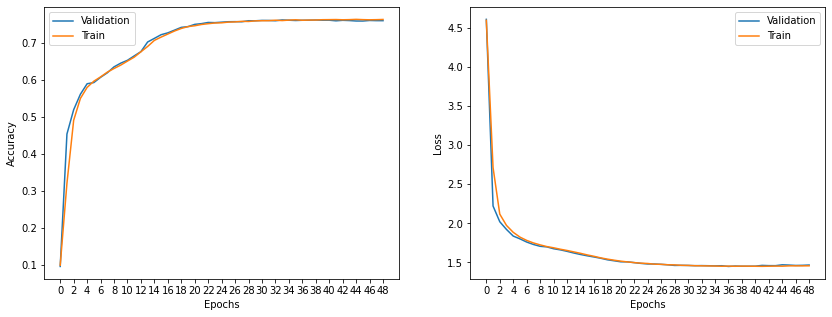

In [66]:
# Plot model history
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

# Plot accuracy history
ax[0].plot(range(len(model1.history['val']['acc'])), model1.history['val']['acc'], label='Validation')
ax[0].plot(range(len(model1.history['train']['acc'])), model1.history['train']['acc'], label='Train')
ax[0].set_xticks(np.arange(0, len(model1.history['val']['acc']), 2)) # Set xticks
ax[0].set_ylabel('Accuracy') # Y axis label
ax[0].set_xlabel('Epochs') # X axis label
ax[0].legend() # Add legend

# Plot loss history
ax[1].plot(range(len(model1.history['val']['loss'])), model1.history['val']['loss'], label='Validation')
ax[1].plot(range(len(model1.history['train']['loss'])), model1.history['train']['loss'], label='Train')
ax[1].set_xticks(np.arange(0, len(model1.history['val']['loss']), 2)) # Set xticks
ax[1].set_ylabel('Loss') # Y axis label
ax[1].set_xlabel('Epochs') # X axis label
ax[1].legend() # Add legend

plt.show();

In [ ]:
# # Build & train second model
# model2 = Model(sizes, weights, biases)
# model2.fit(train_data, epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, validation_size = validation_size, shuffle_order = shuffle_order, store_latent_vecs = True)
# test_acc, test_loss = model2.evaluate(test_data)
# print(f'Test accuracy: {test_acc}. Mean test loss: {test_loss}')

In [ ]:
# # Are model weights reproducible?
# print(f'Model weights were reproducible: {[np.array_equal(model1.weights[i], model2.weights[i]) for i in range(len(model1.weights))]}')

In [ ]:
# # Inspect last layer activations
# last_layer = [model1.feedforward(x, layer_num = 3) for x, y in train_data[:1]]
# print(last_layer[0].sum())
# print(last_layer[0])
# print(train_data[0][1])

## PART 1. Visualize latent space over epochs

In [ ]:
if not os.path.exists('results/p1_model.pkl'):
    # Build & train model
    model = Model(sizes, weights, biases)
    model.fit(train_data, epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, validation_size = validation_size, shuffle_order = shuffle_order, store_latent_vecs = True)
    test_acc, test_loss = model.evaluate(test_data)
    print(f'Test accuracy: {test_acc}. Mean test loss: {test_loss}')

    # Save model to file
    with open('results/p1_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    # Read model from file
    with open('results/p1_model.pkl', 'rb') as f:
        model = pickle.load(f)

In [ ]:
if not os.path.exists('results/p1_history.png'):
    # Plot model history
    fig, ax = plt.subplots(1, 2, figsize = (14, 5))

    # Plot accuracy history
    ax[0].plot(range(len(model.history['val']['acc'])), model.history['val']['acc'], label='Validation')
    ax[0].plot(range(len(model.history['train']['acc'])), model.history['train']['acc'], label='Train')
    ax[0].set_xticks(np.arange(0, len(model.history['val']['acc']), 2)) # Set xticks
    ax[0].set_ylabel('Accuracy') # Y axis label
    ax[0].set_xlabel('Epochs') # X axis label
    ax[0].legend() # Add legend

    # Plot loss history
    ax[1].plot(range(len(model.history['val']['loss'])), model.history['val']['loss'], label='Validation')
    ax[1].plot(range(len(model.history['train']['loss'])), model.history['train']['loss'], label='Train')
    ax[1].set_xticks(np.arange(0, len(model.history['val']['loss']), 2)) # Set xticks
    ax[1].set_ylabel('Loss') # Y axis label
    ax[1].set_xlabel('Epochs') # X axis label
    ax[1].legend() # Add legend

    # Save plot to file
    plt.savefig(f'results/p1_history.png')
    plt.show();
else:
    # Load plot from file
    plt.figure(figsize = (14, 5))
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p1_history.png'))
    plt.axis('off')

In [ ]:
if not os.path.exists('results/p1_latent_over_epochs.png'):
    # Retrieve latent vectors from model history and plot them
    nrows = 7
    ncols = 7
    fig, ax = plt.subplots(nrows, ncols, tight_layout=True, figsize = (ncols * 5, nrows * 5))
    ax = ax.flatten()

    colors = sns.color_palette(['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b','#42d4f4','#4363d8', '#000075', '#911eb4','#f032e6'])

    for epoch in range(0, len(model.history['latent'])):
        # Create dataframe
        df = []
        for index, element in enumerate(model.history['latent'][epoch]):
            vec, label = element
            df.append({'x': vec[0][0], 'y': vec[1][0], 'digit': label})
        df = pd.DataFrame(df)

        # Plot latent vectors in 2D, color-coded by digit
        # print(f'Plotting {len(df)} examples.')
        sns.scatterplot(data=df, x="x", y="y", hue="digit", palette=colors, ax=ax[epoch], legend=False)

        # Add title
        if epoch == 0:
            title = 'Before training'
        else:
            title = f'After epoch {epoch}'
        ax[epoch].set_title(title)

    # Create legend in last subplot
    for i in range(10):
        ax[-1].scatter([], [], color=colors[i], label=i)
    ax[-1].legend()

    # Save plot to file
    plt.savefig(f'results/p1_latent_over_epochs.png')
    plt.show();
else:
    # Load plot from file
    plt.figure(figsize = (35, 35))
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p1_latent_over_epochs.png'))
    plt.axis('off')
    plt.show();

### Quantify latent space similarity versus training loss and model weights

In [ ]:
# Function to get adjacency matrix for a given latent distribution
def get_adjacency_matrix(latent_distribution):
    # Create dataframe
    df = []
    for index, element in enumerate(latent_distribution):
        vec, label = element
        df.append({'x': vec[0][0], 'y': vec[1][0], 'digit': label})
    df = pd.DataFrame(df)

    # Get centroid coordinates
    centroids = df.groupby('digit').mean()

    # Create adjacency matrix
    adjacency_matrix = np.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            if i == j:
                continue
            else:
                adjacency_matrix[i][j] = np.linalg.norm(centroids.iloc[i] - centroids.iloc[j]) # Euclidean distance (L2 norm)
    
    return adjacency_matrix

# Function to compute adjacency spectral distance
def adjacency_spectral_distance(adjacency_matrix_1, adjacency_matrix_2):
    # Compute spectral distance
    eigvals_1, eigvecs_1 = np.linalg.eig(adjacency_matrix_1)
    eigvals_2, eigvecs_2 = np.linalg.eig(adjacency_matrix_2)
    spectral_distance = np.linalg.norm(eigvals_1 - eigvals_2)

    return spectral_distance

In [ ]:
if not os.path.exists('results/p1_adjacency_mean_v_loss.png'):
    # Mean of adjacency matrix vs. training loss
    # Calculate adjacency matrix mean for each epoch, including before training
    adjacency_matrix_means = []
    for epoch in range(0, len(model.history['latent'])):
        adjacency_matrix_means.append(np.mean(get_adjacency_matrix(model.history['latent'][epoch])))

    # Get list of training loss values
    train_losses = model.history['train']['loss']

    # Plot adjacency mean vs. training loss
    # Color by epoch
    plt.scatter(adjacency_matrix_means, model.history['train']['loss'], c=range(len(model.history['train']['loss'])))
    plt.xlabel('Adjacency mean')
    plt.ylabel('Training loss')
    plt.title('Adjacency mean vs. training loss')

    # Save plot to file
    plt.savefig(f'results/p1_adjacency_mean_v_loss.png')
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p1_adjacency_mean_v_loss.png'))
    plt.axis('off')
    plt.show();

In [ ]:
if not os.path.exists('results/p1_cluster_sep_over_epochs.png'):
    # Plot separation between clusters over epochs for all pairs of digits
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows, ncols, tight_layout=True, figsize = (ncols * 5, nrows * 5))
    ax = ax.flatten()

    colors = sns.color_palette(['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b','#42d4f4','#4363d8', '#000075', '#911eb4','#f032e6'])

    for digit1 in range(10):
        dict_of_distances = {}
        for digit2 in range(10):
            distances = []
            for epoch in range(0, len(model.history['latent'])):
                # Get separation between digit1 and digit2 cluster centroids from adjacency matrix
                distances.append(get_adjacency_matrix(model.history['latent'][epoch])[digit1][digit2])
            dict_of_distances[digit2] = distances
        df = pd.DataFrame(dict_of_distances)

        # Plot separation between clusters over epochs for all pairs of digits
        sns.lineplot(data=df, ax=ax[digit1], legend=True)
        ax[digit1].set_title(f'Separation from digit {digit1} over epochs')
        ax[digit1].set_xlabel('Epoch')
        ax[digit1].set_ylabel('Separation')
        ax[digit1].set_xticks(np.arange(0, len(model.history['val']['loss']), 4)) # Set xticks
    
    # Add title
    title = 'Separation between clusters over epochs for all pairs of digits'
    fig.suptitle(title)

    # Save plot to file
    plt.savefig(f'results/p1_cluster_sep_over_epochs.png')
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p1_cluster_sep_over_epochs.png'))
    plt.axis('off')
    plt.show();            

In [ ]:
# if not os.path.exists('results/p1_misclassification_rate.png'):
#     # Plot bar graph of misclassification rates for each class
#     # Get list of misclassification rates
# else:
#     # Load plot from file
#     plt.axes([0,0,1,1])
#     plt.imshow(mpimg.imread('results/p1_misclassification_rate.png'))
#     plt.axis('off')
#     plt.show();

In [ ]:
if not os.path.exists('results/p1_spectral_distance_v_loss_delta.png'):
    # Adjacency spectral distance vs. change in training loss for consecutive epochs
    # Calculate adjacency spectral distance between latent distributions of consecutive epochs (starting from epoch 1)
    spectral_distances = []
    for epoch in range(1, len(model.history['latent']) - 1):
        adjacency_matrix_1 = get_adjacency_matrix(model.history['latent'][epoch])
        adjacency_matrix_2 = get_adjacency_matrix(model.history['latent'][epoch + 1])
        spectral_distances.append(adjacency_spectral_distance(adjacency_matrix_1, adjacency_matrix_2))

    # Get change in training loss between consecutive epochs (starting from epoch 1)
    loss_deltas = []
    for epoch in range(1, len(model.history['train']['loss']) - 1):
        loss_deltas.append(model.history['train']['loss'][epoch + 1] - model.history['train']['loss'][epoch])

    # Plot spectral distance vs. change in training loss
    # Color by epoch
    plt.scatter(spectral_distances, loss_deltas, c=range(1, len(model.history['train']['loss']) - 1))
    plt.xlabel('Spectral distance')
    plt.ylabel('Change in training loss')
    plt.title('Spectral distance vs. change in training loss')

    # Save plot to file
    plt.savefig(f'results/p1_spectral_distance_v_loss_delta.png', bbox_inches='tight')
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p1_spectral_distance_v_loss_delta.png'))
    plt.axis('off')
    plt.show();

In [ ]:
if not os.path.exists('results/p1_spectral_distance_v_weight_distance.png'):
    # Adjacency spectral distance vs. Frobenius weights distance for consecutive epochs
    # Get Frobenius distance between bottleneck weight matrices of consecutive epochs
    weight_distances = []
    for i in range(1, len(model.history['weights']) - 1):
        weight_distances.append(np.linalg.norm(model.history['weights'][i + 1][-2] - model.history['weights'][i][-2])) # Bottleneck layer is second to last layer

    # Plot spectral distance vs. Frobenius weights distance
    plt.scatter(spectral_distances, weight_distances, c=range(1, len(model.history['train']['loss']) - 1))
    plt.xlabel('Spectral distance')
    plt.ylabel('Frobenius weights distance')
    plt.title('Spectral distance vs. Frobenius weights distance')

    # Save plot to file
    plt.savefig(f'results/p1_spectral_distance_v_weight_distance.png')
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p1_spectral_distance_v_weight_distance.png'))
    plt.axis('off')
    plt.show();

## PART 2. Investigate effects of weight initialization on latent space

In [ ]:
# Model architecture
sizes = [784, 30, 2, 10]
epochs = 48
batch_size = 10
learning_rate = 1.5
validation_size=0.3

# Set seed for reproducibility
np.random.seed(0)

# Initialize weights array of shape (num_neurons_i, num_neurons_i-1) for each layer i except the input layer
weights = [np.random.randn(y, x) for y, x in zip(sizes[1:], sizes[:-1])]

# Initialize biases array of shape (num_neurons_i, 1) for each layer i except the input layer
biases = [np.random.randn(y, 1) for y in sizes[1:]] 

# Initialize list of data indices for data shuffling per epoch
shuffle_order = [np.random.permutation(int(len(train_data)*(1 - validation_size))) for i in range(epochs)]

if not os.path.exists('results/p2_models_list.pkl'):
    # Train 20 models with different initial weights of first neuron for first pixel in first hidden layer
    models_list = []
    for idx, variable_weight in enumerate(np.linspace(-2, 2, 20)):
        # Edit initial weight matrix
        new_weights = weights.copy()
        new_weights[0][0][0] = variable_weight
        
        # Build & train model
        print(f'Building model {idx} with initial weight[0][0][0]: {new_weights[0][0][0]:.4f}...')
        model = Model(sizes, weights=new_weights, biases=biases)
        model.fit(train_data, epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, validation_size = validation_size, shuffle_order = shuffle_order, store_latent_vecs = True, verbose=2)
        models_list.append(deepcopy(model)) # Must deepcopy model to avoid overwriting previous models

    # Save models_list to file
    with open(f'results/p2_models_list.pkl', 'wb') as f:
        pickle.dump(models_list, f)
else:
    # Open models_list from file
    with open(f'results/p2_models_list.pkl', 'rb') as f:
        models_list = pickle.load(f)

In [ ]:
if not os.path.exists('results/p2_latent_over_initweights.png'):
    # Visualize final latent space for each model
    nrows = 5
    ncols = 4
    fig, ax = plt.subplots(nrows, ncols, tight_layout=True, figsize = (ncols * 5, nrows * 5))
    ax = ax.flatten()

    colors = sns.color_palette(['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b','#42d4f4','#4363d8', '#000075', '#911eb4','#f032e6'])

    for i, model in enumerate(models_list):
        # Get latent vecs for final epoch
        latent_vecs = model.history['latent'][-1]
        # Create dataframe
        df = []
        for index, element in enumerate(latent_vecs):
            vec, label = element
            df.append({'x': vec[0][0], 'y': vec[1][0], 'digit': label})
        df = pd.DataFrame(df)

        # Plot latent vectors in 2D, color-coded by digit
        # print(f'Plotting {len(df)} examples.')
        sns.scatterplot(data=df, x="x", y="y", hue="digit", palette=colors, ax=ax[i], legend=False)

        # Add title
        title = f'Weight[0][0][0] = {model.initial_weights[0][0][0]}'
        ax[i].set_title(title)

    # Create legend in last subplot
    for i in range(10):
        ax[-1].scatter([], [], color=colors[i], label=i)
    ax[-1].legend()

    # Save plot to file
    plt.savefig(f'results/p2_latent_over_initweights.png');
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p2_latent_over_initweights.png'))
    plt.axis('off')
    plt.show();

In [ ]:
if not os.path.exists('results/p2_spectral_distance_v_weights_delta.png'):
    # Plot latent space similarity (by adjacency spectral distance) versus difference in initial weights, for each pair of models in models_list
    spectral_distances = []
    weight_deltas = []
    for i in range(len(models_list)):
        for j in range(i + 1, len(models_list)):
            # Get adjacency spectral distances of last epoch latent vectors
            adjacency_matrix_1 = get_adjacency_matrix(models_list[i].history['latent'][-1])
            adjacency_matrix_2 = get_adjacency_matrix(models_list[j].history['latent'][-1])
            spectral_distances.append(adjacency_spectral_distance(adjacency_matrix_1, adjacency_matrix_2))

            # Get absolute value difference between initial weights of first neuron for first pixel in first hidden layer
            weight_difference = np.abs(models_list[i].initial_weights[0][0][0] - models_list[j].initial_weights[0][0][0])
            weight_deltas.append(weight_difference)

    # Plot spectral distance vs. change in training loss
    # Color by epoch
    plt.scatter(spectral_distances, weight_deltas)
    plt.xlabel('Spectral distance')
    plt.ylabel('Difference in initial weight of first neuron in first hidden layer')
    plt.title('Spectral distance vs. difference in initial weight of first neuron in first hidden layer')

    # Save plot to file
    plt.savefig(f'results/p2_spectral_distance_v_weights_delta.png', bbox_inches='tight')
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p2_spectral_distance_v_weights_delta.png'))
    plt.axis('off')
    plt.show();

In [ ]:
if not os.path.exists('results/p2_adjacency_mean_v_loss.png'):
    # Plot mean adjacency versus final training loss for each model in models_list
    
    # Calculate mean adjacency for each model
    adjacency_means = []
    for model in models_list:
        adjacency_means.append(np.mean(get_adjacency_matrix(model.history['latent'][-1])))
    
    # Get final training loss for each model
    final_losses = []
    for model in models_list:
        final_losses.append(model.history['train']['loss'][-1])

    # Plot mean adjacency versus final training loss
    plt.scatter(adjacency_means, final_losses)
    plt.xlabel('Adjacency mean')
    plt.ylabel('Final training loss')
    plt.title('Mean adjacency versus final training loss')

    # Save plot to file
    plt.savefig(f'results/p2_adjacency_mean_v_loss.png', bbox_inches='tight')
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p2_adjacency_mean_v_loss.png'))
    plt.axis('off')
    plt.show();

## Part 3. Full random search of initial weights

In [ ]:
# Model architecture
sizes = [784, 30, 2, 10]
epochs = 24
batch_size = 10
learning_rate = 1.5
validation_size = 0.3

# Set seed for reproducibility
np.random.seed(0)

# Initialize biases array of shape (num_neurons_i, 1) for each layer i except the input layer
biases = [np.random.randn(y, 1) for y in sizes[1:]] 

# Initialize list of data indices for data shuffling per epoch
shuffle_order = [np.random.permutation(int(len(train_data)*(1 - validation_size))) for i in range(epochs)]

if not os.path.exists('results/p3_models_list.pkl'):
    # Train 100 models with different initial weights
    models_list = []
    for idx, i in enumerate(range(100)):
        # Initialize weights array of shape (num_neurons_i, num_neurons_i-1) for each layer i except the input layer
        weights = [np.random.randn(y, x) for y, x in zip(sizes[1:], sizes[:-1])]
        
        # Build & train model
        print(f'Training model {idx}...')
        model = Model(sizes, weights, biases)
        model.fit(train_data, epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, validation_size = validation_size, shuffle_order = shuffle_order, store_latent_vecs = True, verbose=0)
        models_list.append(deepcopy(model)) # Deepcopy to avoid overwriting previous models

    # Save models_list to file
    with open(f'results/p3_models_list.pkl', 'wb') as f:
        pickle.dump(models_list, f)
else:
    # Open models_list from file
    with open(f'results/p3_models_list.pkl', 'rb') as f:
        models_list = pickle.load(f)

In [ ]:
if not os.path.exists('results/p3_latent_over_initweights.png'):
    # Visualize final latent space for each model
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows, ncols, tight_layout=True, figsize = (ncols * 5, nrows * 5))
    ax = ax.flatten()

    colors = sns.color_palette(['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b','#42d4f4','#4363d8', '#000075', '#911eb4','#f032e6'])

    for i, model in enumerate(models_list):
        # Get latent vecs for final epoch
        latent_vecs = model.history['latent'][-1]
        # Create dataframe
        df = []
        for index, element in enumerate(latent_vecs):
            vec, label = element
            df.append({'x': vec[0][0], 'y': vec[1][0], 'digit': label})
        df = pd.DataFrame(df)

        # Plot latent vectors in 2D, color-coded by digit
        # print(f'Plotting {len(df)} examples.')
        sns.scatterplot(data=df, x="x", y="y", hue="digit", palette=colors, ax=ax[i], legend=False)

        # Add title
        title = f'Validation accuracy: {model.history["val"]["acc"][-1]:.2f}'
        ax[i].set_title(title)

    # Create legend in last subplot
    for i in range(10):
        ax[-1].scatter([], [], color=colors[i], label=i)
    ax[-1].legend()

    # Save plot to file
    plt.savefig(f'results/p3_latent_over_initweights.png');
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p3_latent_over_initweights.png'))
    plt.axis('off')
    plt.show();

In [ ]:
if not os.path.exists('results/p3_acc_over_initweights.png'):
    # Plot histogram of final training accuracy
    plt.hist([model.history['train']['acc'][-1] for model in models_list], bins=10)
    plt.xlabel('Final training accuracy')
    plt.ylabel('Number of models')
    plt.title(f'Variation in training accuracy after {len(models_list[0].history["train"]["loss"]) - 1} epochs')
    plt.savefig(f'results/p3_acc_over_initweights.png');
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p3_acc_over_initweights.png'))
    plt.axis('off')
    plt.show();

In [ ]:
if not os.path.exists('results/p3_perf_over_initweights.png'):
    # Plot training history for each model
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows, ncols, tight_layout=True, figsize = (ncols * 5, nrows * 5))
    ax = ax.flatten()

    for i, model in enumerate(models_list):
        # Plot accuracy history
        ax[i].plot(range(len(model.history['val']['acc'])), model.history['val']['acc'], label='Validation')
        ax[i].plot(range(len(model.history['train']['acc'])), model.history['train']['acc'], label='Train')
        ax[i].set_xticks(np.arange(0, len(model.history['val']['acc']), 2)) # Set xticks
        ax[i].set_ylabel('Accuracy') # Y axis label
        ax[i].set_xlabel('Epochs') # X axis label
        ax[i].legend() # Add legend

        # Add title
        title = f'Randomly initialized model {i}'
        ax[i].set_title(title)

    # Save plot to file
    plt.savefig(f'results/p3_perf_over_initweights.png');
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p3_perf_over_initweights.png'))
    plt.axis('off')
    plt.show();

In [ ]:
if not os.path.exists('results/p3_initweights_dist_v_spectral_dist.png'):
    # Plot Frobenius distance of first hidden layer initial weights versus spectral distance for each pair of models
    frobenius_dists = []
    spectral_dists = []    
    for i, model1 in enumerate(models_list):
        for j, model2 in enumerate(models_list):
            if i != j:
                # Get first hidden layer initial weights for each model
                init_weights_i = model1.initial_weights[0]
                init_weights_j = model2.initial_weights[0]
                # Get Frobenius distance
                frobenius_dists.append(np.linalg.norm(init_weights_i - init_weights_j))
                # Get spectral distance of last epoch latent vectors
                adjacency_matrix_1 = get_adjacency_matrix(model1.history['latent'][-1])
                adjacency_matrix_2 = get_adjacency_matrix(model2.history['latent'][-1])
                spectral_dists.append(adjacency_spectral_distance(adjacency_matrix_1, adjacency_matrix_2))
    
    # Plot Frobenius distance vs. spectral distance
    plt.scatter(spectral_dists, frobenius_dists)
    plt.xlabel('Spectral distance')
    plt.ylabel('Frobenius distance')
    plt.title(f'Frobenius distance of first hidden layer initial weights vs. spectral distance after {len(model1.history["train"]["loss"]) - 1} epochs')

    # Save plot to file
    plt.savefig(f'results/p3_initweights_dist_v_spectral_dist.png');
    plt.show();

else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p3_initweights_dist_v_spectral_dist.png'))
    plt.axis('off')
    plt.show();


In [ ]:
if not os.path.exists('results/p3_spectral_dist_v_loss_diff.png'):
    # Plot spectral distance versus loss difference for each pair of models
    spectral_dists = []
    loss_diffs = []
    for i, model1 in enumerate(models_list):
        for j, model2 in enumerate(models_list):
            if i < j:
                # Get spectral distance of last epoch latent vectors
                adjacency_matrix_1 = get_adjacency_matrix(model1.history['latent'][-1])
                adjacency_matrix_2 = get_adjacency_matrix(model2.history['latent'][-1])
                spectral_dists.append(adjacency_spectral_distance(adjacency_matrix_1, adjacency_matrix_2))
                # Get absolute loss difference
                loss_diffs.append(abs(model1.history['train']['loss'][-1] - model2.history['train']['loss'][-1]))

    # Plot spectral distance vs. loss difference
    plt.scatter(spectral_dists, loss_diffs)
    plt.xlabel('Spectral distance')
    plt.ylabel('Loss difference')
    plt.title(f"Spectral distance vs. loss difference after {len(model1.history['train']['loss']) - 1} epochs")

    # Save plot to file
    plt.savefig(f'results/p3_spectral_dist_v_loss_diff.png');
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p3_spectral_dist_v_loss_diff.png'))
    plt.axis('off')
    plt.show();

In [ ]:
if not os.path.exists('results/p3_initweights_dist_v_loss_diff.png'):
    # Plot Frobenius distance versus loss difference for each pair of models
    frobenius_dists = []
    loss_diffs = []
    for i, model1 in enumerate(models_list):
        for j, model2 in enumerate(models_list):
            if i < j:
                # Get first hidden layer initial weights for each model
                init_weights_i = model1.initial_weights[0]
                init_weights_j = model2.initial_weights[0]
                # Get Frobenius distance
                frobenius_dists.append(np.linalg.norm(init_weights_i - init_weights_j))
                # Get absolute loss difference
                loss_diffs.append(abs(model1.history['train']['loss'][-1] - model2.history['train']['loss'][-1]))

    # Plot Frobenius distance vs. loss difference
    plt.scatter(frobenius_dists, loss_diffs)
    plt.xlabel('Frobenius distance')
    plt.ylabel('Loss difference')
    plt.title(f"Frobenius distance vs. loss difference after {len(model1.history['train']['loss']) - 1} epochs")

    # Save plot to file
    plt.savefig(f'results/p3_initweights_dist_v_loss_diff.png');
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p3_initweights_dist_v_loss_diff.png'))
    plt.axis('off')
    plt.show();

In [ ]:
if not os.path.exists('results/p3_adjacency_heatmaps.png'):
    # Plot heatmap of adjacency matrix for each model in models_list
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows, ncols, tight_layout=True, figsize = (ncols * 5, nrows * 5))
    ax = ax.flatten()

    for i, model in enumerate(models_list):
        # Get adjacency matrix
        adjacency_matrix = get_adjacency_matrix(model.history['latent'][-1])
        # Plot heatmap
        ax[i].imshow(adjacency_matrix, cmap='magma')
        ax[i].set_title(f'Last epoch training accuracy: {model.history["train"]["acc"][-1]:.2f}')
        
    # Save plot to file
    plt.savefig(f'results/p3_adjacency_heatmaps.png');
    plt.show();
else:
    # Load plot from file
    plt.axes([0,0,1,1])
    plt.imshow(mpimg.imread('results/p3_adjacency_heatmaps.png'))
    plt.axis('off')
    plt.show();